In [1]:
# Imports for no-FAISS pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


# **distillgpt2_finalized_without_FAISS**

In [ ]:
# Cell 2: Load & preprocess the CSV (same as before, but we won’t build embeddings/FAISS)
url = "https://huggingface.co/datasets/panda04/smart-home-dataset/raw/main/smart_home_dataset.csv"
data = pd.read_csv(url)

def preprocess_data(df):
    df = df.drop(['Transaction_ID', 'Unix Timestamp'], axis=1)

    # Temporal features
    df['is_peak_hour'] = df['Hour of the Day'].apply(lambda x: 1 if (6 <= x <= 9) or (18 <= x <= 21) else 0)
    df['part_of_day'] = pd.cut(
        df['Hour of the Day'],
        bins=[0, 6, 12, 18, 24],
        labels=['night', 'morning', 'afternoon', 'evening']
    )
    df['is_weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

    # Seasonal features
    season_dict = {
        'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
        'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
        'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
        'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
    }
    df['Season'] = df['Month'].map(season_dict)

    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour of the Day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour of the Day'] / 24)

    # Energy features
    appliances = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    df['total_appliance_usage'] = df[appliances].sum(axis=1)
    consumption_threshold = df['Energy Consumption (kWh)'].quantile(0.75)
    df['is_high_consumption'] = df['Energy Consumption (kWh)'].apply(
        lambda x: 1 if x > consumption_threshold else 0
    )

    # Scale numeric features (optional; primarily for consistency)
    from sklearn.preprocessing import MinMaxScaler
    features_to_scale = ['Line Voltage', 'Voltage', 'Apparent Power', 'Energy Consumption (kWh)']
    df[features_to_scale] = MinMaxScaler().fit_transform(df[features_to_scale])

    # Compute efficiency ratios and other derived columns
    for appliance in appliances:
        df[f'{appliance}_efficiency_ratio'] = df[appliance] / (df['Energy Consumption (kWh)'] + 1e-6)

    df['power_factor'] = df['Apparent Power'] / (df['Line Voltage'] * df['Voltage'] + 1e-6)
    df['active_appliances'] = df[appliances].sum(axis=1)
    df['energy_per_active_appliance'] = df['Energy Consumption (kWh)'] / (df['active_appliances'] + 1e-6)

    return df

data = preprocess_data(data)
print("✅ Data loaded and preprocessed. Total rows:", len(data))


✅ Data loaded and preprocessed. Total rows: 48972


In [ ]:
# Cell 3: Load the saved fine‐tuned model & tokenizer (from wherever you saved it)
#
# If you mounted Drive earlier, set save_path accordingly (e.g. "/content/drive/MyDrive/saved_energy_model")
# Otherwise, if it’s in the notebook’s working directory, just use "./saved_energy_model".

save_path = "./saved_energy_model"  # <-- adjust if yours is in Drive or another path
tokenizer = AutoTokenizer.from_pretrained(save_path)
llm_model = AutoModelForCausalLM.from_pretrained(save_path).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)

print("✅ Model and tokenizer loaded from:", save_path)


✅ Model and tokenizer loaded from: ./saved_energy_model


In [ ]:
# Cell 4: Build a SINGLE‐ROW prompt (no FAISS) and generate tips

device = "cuda" if torch.cuda.is_available() else "cpu"

def build_single_row_prompt(idx):
    """
    Given a row index `idx`, construct a text prompt that describes that one data point,
    then appends the instruction to recommend five bullet‐list energy tips.
    """
    row = data.iloc[idx]
    # Manually list out each feature you care about in a concise way:
    appliances_status = ", ".join(
        # Changed 'row[appl]' to 'row[app]'
        f"{app}:ON" if row[app] > 0 else f"{app}:OFF"
        for app in ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    )

    # Example prompt structure (you can tweak wording as desired):
    prompt = (
        f"Context:\n"
        f"- Hour: {int(row['Hour of the Day'])} ({row['part_of_day']})\n"
        f"- Season: {row['Season']}\n"
        f"- Day of Week: {row['Day of the Week']}\n"
        f"- Active Appliances: {appliances_status}\n"
        f"- Total Energy Consumption: {row['Energy Consumption (kWh)']:.2f} kWh\n"
        f"- High Consumption?: {'Yes' if row['is_high_consumption'] == 1 else 'No'}\n\n"
        f"Now, recommend exactly five bullet‐list energy‐saving tips:\n"
        f"Tips:"
    )
    return prompt

def generate_tips_no_faiss(idx):
    # 1) Build prompt for that row
    prompt = build_single_row_prompt(idx)

    # 2) Tokenize WITHOUT truncation so “Tips:” stays intact
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=False,
        max_length=None
    ).to(device)

    # 3) Generate up to 80 new tokens (should cover ~5 bullets)
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=80,
        num_beams=5,
        temperature=0.6,
        no_repeat_ngram_size=2,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

    # 4) Decode full output (prompt + continuation)
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
    # Print raw (for debugging)
    # print("----- RAW OUTPUT -----\n", full_output, "\n----------------------\n")

    # 5) Strip off the prompt prefix, leaving only anything after "Tips:"
    if full_output.startswith(prompt):
        remainder = full_output[len(prompt):].strip()
    else:
        remainder = full_output.replace(prompt, "").strip()

    # 6) If a double‐newline appears (model ended), only keep up to that point
    if "\n\n" in remainder:
        remainder = remainder.split("\n\n")[0].strip()

    # 7) Extract lines starting with "- "
    lines = [line for line in remainder.split("\n") if line.strip().startswith("-")]

    # 8) Return at most five bullets (join by newline)
    return "\n".join(lines[:5])

# Example: generate for row index 100
print("=== Sample output for row 100 ===")
print(generate_tips_no_faiss(100))
print("\n=== Sample output for row 50 ===")
print(generate_tips_no_faiss(50))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


=== Sample output for row 100 ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


- Use cold water instead of water to reduce energy use.  

=== Sample output for row 50 ===
- Use cold water instead of water to reduce energy use and save energy.  


In [ ]:
# Cell 5: (Optional) Loop through multiple indices
for idx in [10, 25, 100]:
    print(f"\n--- Energy Tips for index {idx} ---")
    print(generate_tips_no_faiss(idx))


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Energy Tips for index 10 ---


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


- Turn off oven-heater door-to-door when not in use: ⅔ 5 minutes, not sure how long it takes to set it on fire.  

--- Energy Tips for index 25 ---


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


- Use cold water instead of water to reduce energy use and save energy.  

--- Energy Tips for index 100 ---
- Use cold water instead of water to reduce energy use.  


# CHARTS

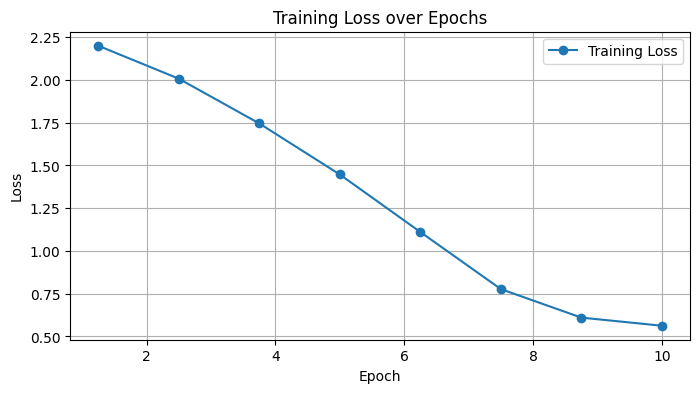

<ipython-input-45-57269f4fcf34>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_logs['perplexity'] = np.exp(loss_logs['loss'])


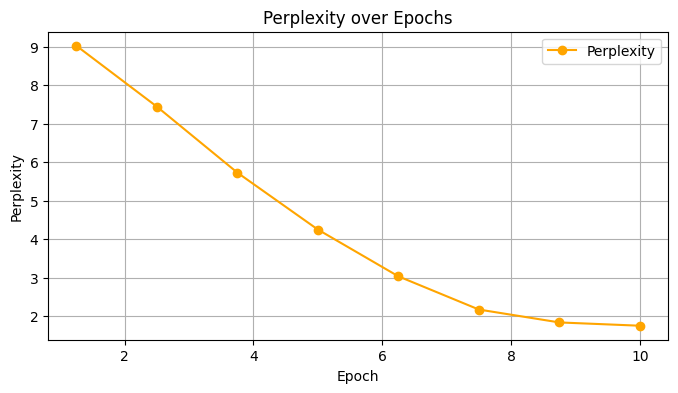

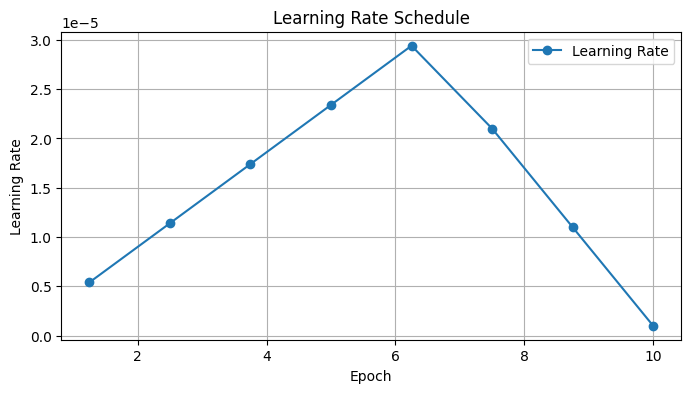

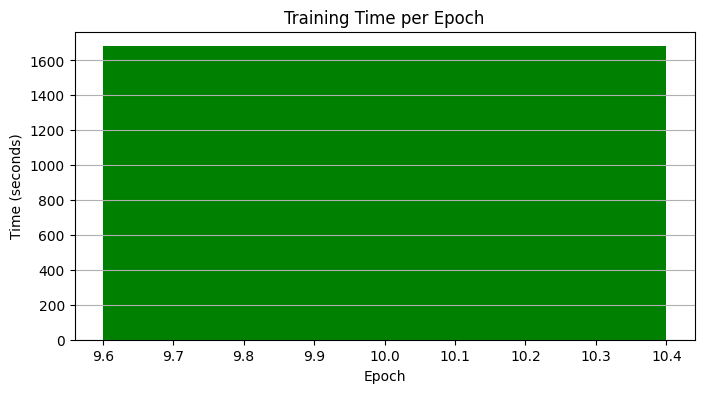

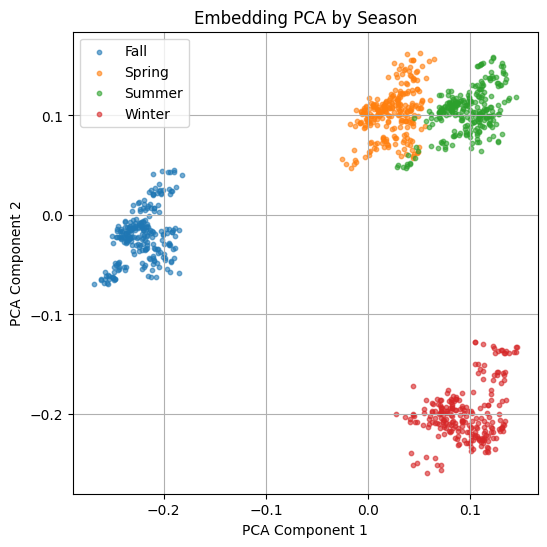

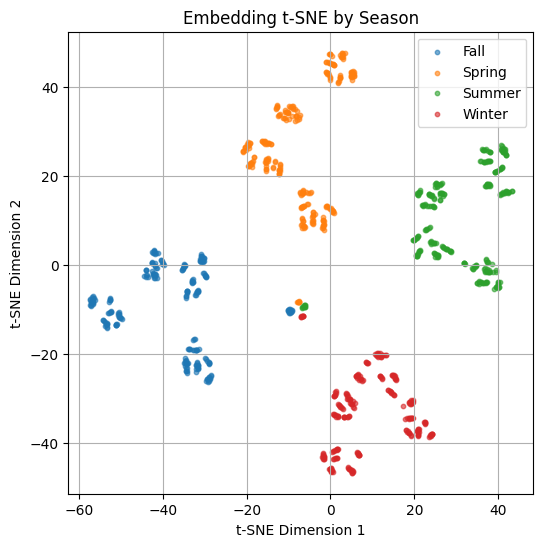

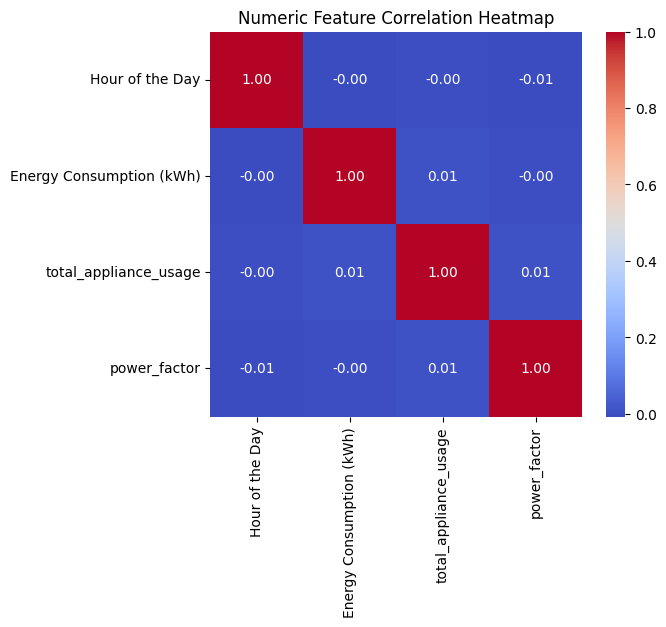

KeyboardInterrupt: 

In [ ]:
# Cell Y: Plot loss, perplexity, learning rate, training time, embeddings, heatmap, hit rate

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# 1) Extract log history from trainer
log_history = pd.DataFrame(trainer.state.log_history)

# --------------------------------------------------------------------------------
# 1. Training Loss & Perplexity Curves
# --------------------------------------------------------------------------------
loss_logs = log_history[log_history['loss'].notna()]
plt.figure(figsize=(8, 4))
plt.plot(loss_logs['epoch'], loss_logs['loss'], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Compute Perplexity = exp(loss)
loss_logs['perplexity'] = np.exp(loss_logs['loss'])
plt.figure(figsize=(8, 4))
plt.plot(loss_logs['epoch'], loss_logs['perplexity'], marker='o', color='orange', label='Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 2. Learning Rate Schedule
# --------------------------------------------------------------------------------
lr_logs = log_history[log_history['learning_rate'].notna()]
plt.figure(figsize=(8, 4))
plt.plot(lr_logs['epoch'], lr_logs['learning_rate'], marker='o', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 3. Training Time per Epoch (if available)
# --------------------------------------------------------------------------------
if 'train_runtime' in log_history.columns:
    time_logs = log_history[log_history['train_runtime'].notna()]
    plt.figure(figsize=(8, 4))
    plt.bar(time_logs['epoch'], time_logs['train_runtime'], color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Training Time per Epoch')
    plt.grid(axis='y')
    plt.show()

# --------------------------------------------------------------------------------
# 4. Embeddings Visualization (PCA & t-SNE)
# --------------------------------------------------------------------------------
# Assuming `embeddings` (NumPy array) and `data` (DataFrame) are still in memory:
n_sample = min(1000, embeddings.shape[0])
indices = np.random.choice(range(embeddings.shape[0]), n_sample, replace=False)
sample_emb = embeddings[indices]
sample_labels = data['Season'].iloc[indices].values  # color by season

# PCA
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(sample_emb)
plt.figure(figsize=(6, 6))
for season in np.unique(sample_labels):
    mask = sample_labels == season
    plt.scatter(emb_pca[mask, 0], emb_pca[mask, 1], label=season, alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Embedding PCA by Season')
plt.legend()
plt.grid(True)
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(sample_emb)
plt.figure(figsize=(6, 6))
for season in np.unique(sample_labels):
    mask = sample_labels == season
    plt.scatter(emb_tsne[mask, 0], emb_tsne[mask, 1], label=season, alpha=0.6, s=10)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Embedding t-SNE by Season')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 5. Heatmap of Numeric Feature Correlation
# --------------------------------------------------------------------------------
numeric_cols = ['Hour of the Day', 'Energy Consumption (kWh)', 'total_appliance_usage', 'power_factor']
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numeric Feature Correlation Heatmap')
plt.show()

# --------------------------------------------------------------------------------
# 6. Top-N Recommendation Hit Rate (Simulated)
# --------------------------------------------------------------------------------
def hit_rate_off_peak(idx):
    tips = generate_energy_tips(idx).lower()
    return 1 if 'off-peak' in tips else 0

hit_rates = [hit_rate_off_peak(i) for i in range(len(data))]
avg_hit = np.mean(hit_rates)
plt.figure(figsize=(6, 4))
plt.bar(['Hit Rate'], [avg_hit], color='purple')
plt.ylabel('Hit Rate')
plt.title('Simulated Hit Rate for "off-peak" Tip')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# Evaluation metrics and bar charts

In [ ]:
# Cell Y: Re‐train (or rerun) your LSTM and capture the History
history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
918/918 [==============================] - 15s 15ms/step - loss: 0.1824 - mae: 0.3644 - val_loss: 0.1920 - val_mae: 0.3643
Epoch 2/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1816 - mae: 0.3631 - val_loss: 0.1919 - val_mae: 0.3640
Epoch 3/20
918/918 [==============================] - 14s 15ms/step - loss: 0.1808 - mae: 0.3615 - val_loss: 0.1924 - val_mae: 0.3626
Epoch 4/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1798 - mae: 0.3600 - val_loss: 0.1929 - val_mae: 0.3688
Epoch 5/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1785 - mae: 0.3566 - val_loss: 0.1935 - val_mae: 0.3564
Epoch 6/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1774 - mae: 0.3551 - val_loss: 0.1940 - val_mae: 0.3612
Epoch 7/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1757 - mae: 0.3513 - val_loss: 0.1952 - val_mae: 0.3633
Epoch 8/20
918/918 [==============================] - 13s 14ms

In [ ]:
# Cell Y+1: Turn the history into a DataFrame and display it
import pandas as pd

# history.history is a dict, keys like 'loss', 'val_loss', 'mae', 'val_mae'
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1

# show the table of all metrics per epoch
display(hist_df)


,loss,mae,val_loss,val_mae,epoch
0,0.182398,0.364363,0.191953,0.364257,1
1,0.181584,0.363077,0.191897,0.363977,2
2,0.180791,0.361508,0.192427,0.362564,3
3,0.179815,0.359981,0.192927,0.368838,4
4,0.178527,0.356624,0.193521,0.356406,5
5,0.177408,0.355129,0.193991,0.361189,6
6,0.175669,0.351281,0.195249,0.363302,7
7,0.175296,0.350521,0.195708,0.359122,8
8,0.173866,0.347594,0.195931,0.354486,9
9,0.172564,0.345488,0.196573,0.354282,10


In [ ]:
history = lstm_model.fit(train_ds, validation_data=val_ds, epochs=20)


Epoch 1/20
918/918 [==============================] - 12s 14ms/step - loss: 0.1560 - mae: 0.3138 - val_loss: 0.2034 - val_mae: 0.3531
Epoch 2/20
918/918 [==============================] - 12s 14ms/step - loss: 0.1547 - mae: 0.3117 - val_loss: 0.2045 - val_mae: 0.3520
Epoch 3/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1530 - mae: 0.3095 - val_loss: 0.2058 - val_mae: 0.3462
Epoch 4/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1507 - mae: 0.3042 - val_loss: 0.2051 - val_mae: 0.3503
Epoch 5/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1499 - mae: 0.3030 - val_loss: 0.2073 - val_mae: 0.3489
Epoch 6/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1490 - mae: 0.3005 - val_loss: 0.2067 - val_mae: 0.3529
Epoch 7/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1467 - mae: 0.2974 - val_loss: 0.2057 - val_mae: 0.3471
Epoch 8/20
918/918 [==============================] - 13s 14ms

In [ ]:
# Cell A: Convert history into a DataFrame
import pandas as pd

# history.history is a dict with keys: 'loss', 'val_loss', 'mae', 'val_mae'
hist_df = pd.DataFrame(history.history)
hist_df.index = hist_df.index + 1           # make epochs 1-based
hist_df.index.name = 'epoch'
display(hist_df)


,loss,mae,val_loss,val_mae
epoch,,,,
1,0.155967,0.313768,0.203389,0.353139
2,0.154711,0.311698,0.204508,0.351958
3,0.153026,0.309502,0.205837,0.346236
4,0.150683,0.304215,0.205068,0.350257
5,0.149924,0.302991,0.207255,0.348850
6,0.148979,0.300498,0.206690,0.352851
7,0.146718,0.297432,0.205708,0.347070
8,0.146621,0.297639,0.211921,0.353417
9,0.145067,0.293984,0.211744,0.352281


In [ ]:
# Cell B: Extract each metric into its own “table” and display

# Table 1: training loss by epoch
table_loss = hist_df[['loss']].copy()
table_loss.columns = ['Train Loss']
display(table_loss)

# Table 2: validation loss by epoch
table_val_loss = hist_df[['val_loss']].copy()
table_val_loss.columns = ['Val Loss']
display(table_val_loss)

# Table 3: training MAE by epoch
table_mae = hist_df[['mae']].copy()
table_mae.columns = ['Train MAE']
display(table_mae)

# Table 4: validation MAE by epoch
table_val_mae = hist_df[['val_mae']].copy()
table_val_mae.columns = ['Val MAE']
display(table_val_mae)

# Table 5: combined summary (loss & MAE)
table_summary = hist_df[['loss','val_loss','mae','val_mae']].copy()
table_summary.columns = ['Train Loss','Val Loss','Train MAE','Val MAE']
display(table_summary)


,Train Loss
epoch,
1,0.155967
2,0.154711
3,0.153026
4,0.150683
5,0.149924
6,0.148979
7,0.146718
8,0.146621
9,0.145067


,Val Loss
epoch,
1,0.203389
2,0.204508
3,0.205837
4,0.205068
5,0.207255
6,0.206690
7,0.205708
8,0.211921
9,0.211744


,Train MAE
epoch,
1,0.313768
2,0.311698
3,0.309502
4,0.304215
5,0.302991
6,0.300498
7,0.297432
8,0.297639
9,0.293984


,Val MAE
epoch,
1,0.353139
2,0.351958
3,0.346236
4,0.350257
5,0.348850
6,0.352851
7,0.347070
8,0.353417
9,0.352281


,Train Loss,Val Loss,Train MAE,Val MAE
epoch,,,,
1,0.155967,0.203389,0.313768,0.353139
2,0.154711,0.204508,0.311698,0.351958
3,0.153026,0.205837,0.309502,0.346236
4,0.150683,0.205068,0.304215,0.350257
5,0.149924,0.207255,0.302991,0.348850
6,0.148979,0.206690,0.300498,0.352851
7,0.146718,0.205708,0.297432,0.347070
8,0.146621,0.211921,0.297639,0.353417
9,0.145067,0.211744,0.293984,0.352281


<Figure size 800x300 with 0 Axes>

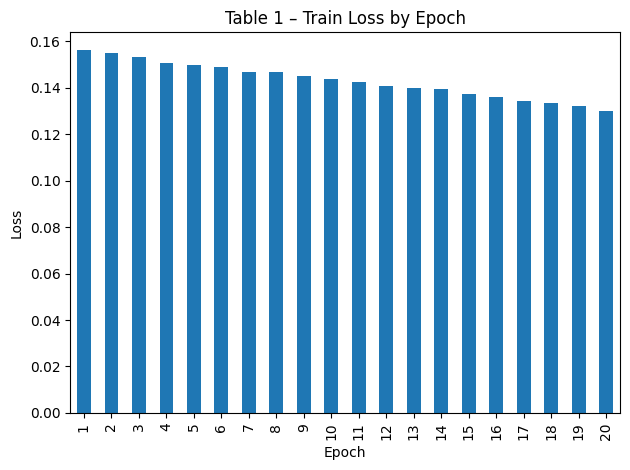

<Figure size 800x300 with 0 Axes>

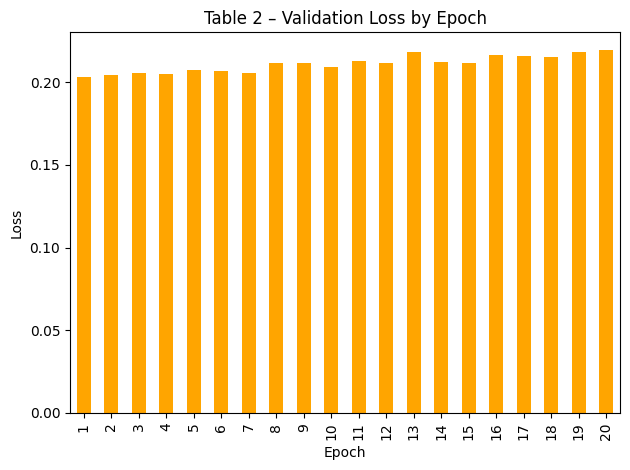

<Figure size 800x300 with 0 Axes>

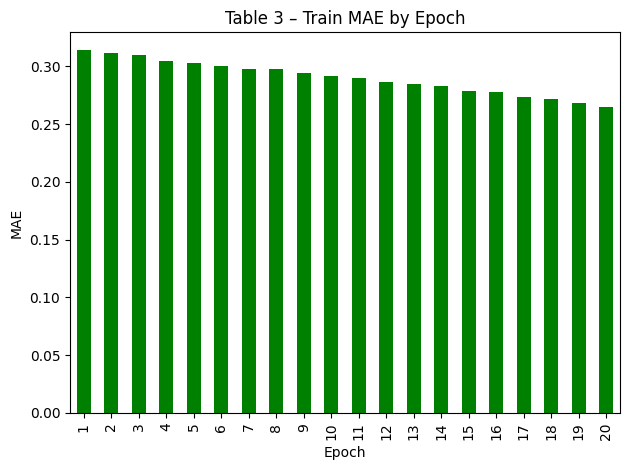

<Figure size 800x300 with 0 Axes>

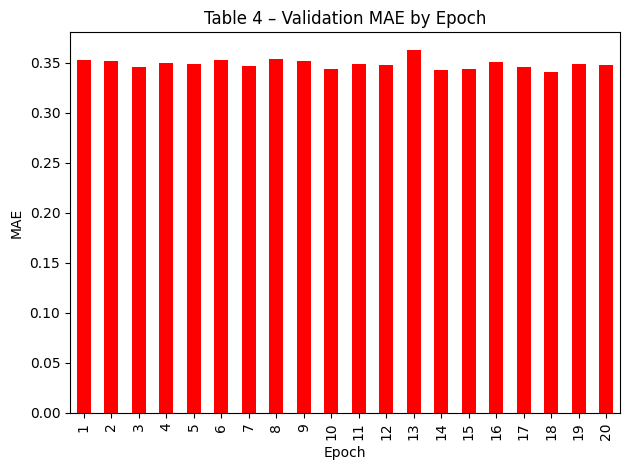

<Figure size 1000x400 with 0 Axes>

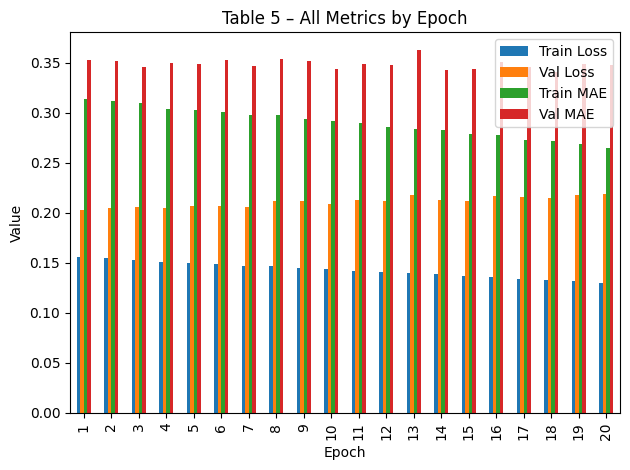

In [ ]:
# Cell C: Bar‐chart for each of these 5 tables

import matplotlib.pyplot as plt

# 1) Train Loss
plt.figure(figsize=(8,3))
table_loss.plot(kind='bar', legend=False)
plt.title("Table 1 – Train Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

# 2) Val Loss
plt.figure(figsize=(8,3))
table_val_loss.plot(kind='bar', legend=False, color='orange')
plt.title("Table 2 – Validation Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

# 3) Train MAE
plt.figure(figsize=(8,3))
table_mae.plot(kind='bar', legend=False, color='green')
plt.title("Table 3 – Train MAE by Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

# 4) Val MAE
plt.figure(figsize=(8,3))
table_val_mae.plot(kind='bar', legend=False, color='red')
plt.title("Table 4 – Validation MAE by Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

# 5) Combined Summary
plt.figure(figsize=(10,4))
table_summary.plot(kind='bar')
plt.title("Table 5 – All Metrics by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
